In [1]:
# tool kit
import warnings
warnings.filterwarnings('ignore')
from pandas.plotting import autocorrelation_plot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
#MAPE Mean Abosolute Percetage Error
def mean_absolute_porcentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

In [4]:
#Ho: Não é estacionário
#H1: É estacionário

def adfuller_test(Vendas):
    
    result=adfuller(Vendas)
    
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
   
    # se a significância estiver abaixo de 0.05, significa que há pouca influência nos dados. 
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis, indicating it is non-stationary ")

In [5]:
def TRANSFORMA_HORA(df):
    '''
    Parâmetro : dataframe
    -------------------------------------------------------------------
    O que faz: Adequa a coluna 'DT_MEDICAO' 
    para ficar {ano-mes-dia hora:min:seg}
    --------------------------------------------------------------------
    Retorna: O head() do dataframe com o formato em datetime com 
    formato descrito
    
    '''
    df.loc[:,'DT_MEDICAO'] =  pd.to_datetime(df.loc[:,'DT_MEDICAO'], format='%Y-%m-%d')
    
    def TRANSFORMA_HORA(df):
        '''Transformando o df['HR_MEDICAO'] que está em UTC para o correspondente para o BRASIL.
        Sendo a hora 0 = 21h.
        Criando uma coluna ['HR'] para esses valores  '''
        hora_br = 0
        HORA=[]

        for hora in df['HR_MEDICAO']:
            if hora/100+21 >= 25:
                hora_br = (hora/100+21)-24
            else:
                hora_br = hora/100+21
            HORA.append(hora_br)
        df.loc[:,'HORA'] = HORA
        df['HORA'] = df['HORA'].astype(int)
        
    # usa a função que tranforma a coluna HR_MEDICAO que está em UTC em formato 24h
    TRANSFORMA_HORA(df)
    
    #trasformando a timeseries no index
    #df.set_index('DT_MEDICAO', drop=True, inplace=True)                                    
    #df.index = pd.DatetimeIndex(df.index)
    return df.head()   

In [6]:
pd.set_option('display.max_row',10000)
pd.set_option('display.max_columns',40)

In [7]:
#Lendo o arquivo não tratado
df = pd.read_csv('Dados/data_raw.csv',sep=';')

In [8]:
TRANSFORMA_HORA(df)

,DC_NOME,PRE_INS,TEM_SEN,VL_LATITUDE,PRE_MAX,UF,RAD_GLO,PTO_INS,TEM_MIN,VL_LONGITUDE,UMD_MIN,PTO_MAX,VEN_DIR,DT_MEDICAO,CHUVA,PRE_MIN,UMD_MAX,VEN_VEL,PTO_MIN,TEM_MAX,VEN_RAJ,TEM_INS,UMD_INS,CD_ESTACAO,HR_MEDICAO,HORA
0,SAO PAULO - MIRANTE,922.4,19.5,-23.496294,922.4,SP,-2.090,17.1,20.6,-46.620088,78.0,17.3,130.0,2011-01-01,0.0,921.9,81.0,2.4,16.9,20.9,6.1,20.6,80.0,A701,0,21
1,SAO PAULO - MIRANTE,922.8,18.2,-23.496294,922.8,SP,-3.286,17.4,20.1,-46.620088,80.0,17.6,110.0,2011-01-01,0.0,922.4,86.0,3.1,17.1,20.7,6.4,20.4,83.0,A701,100,22
2,SAO PAULO - MIRANTE,922.6,18.4,-23.496294,922.9,SP,-2.241,17.2,20.3,-46.620088,82.0,17.5,124.0,2011-01-01,0.0,922.6,83.0,3.0,17.2,20.5,6.4,20.4,82.0,A701,200,23
3,SAO PAULO - MIRANTE,921.9,19.4,-23.496294,922.6,SP,-2.836,17.1,20.0,-46.620088,81.0,17.2,128.0,2011-01-01,0.0,921.9,83.0,2.2,17.0,20.4,6.0,20.1,83.0,A701,300,24
4,SAO PAULO - MIRANTE,921.3,19.7,-23.496294,921.9,SP,-1.719,17.2,20.0,-46.620088,83.0,17.2,122.0,2011-01-01,0.0,921.3,84.0,2.0,17.1,20.1,5.8,20.0,84.0,A701,400,1


In [9]:
#Concatenando as horas a data
df.loc[df["HORA"] == 24, "HORA"] = 0
df=df.astype({'HORA':'string'})
df['HORA']=df['HORA'] + ':00:00'
df=df.astype({'DT_MEDICAO':'string'})
df['DT_MEDICAO']=df['DT_MEDICAO']+ ' '+df['HORA']

In [10]:
ts_rad=df[['DT_MEDICAO', 'RAD_GLO']]

In [11]:
#transformando para Date Time
ts_rad['DT_MEDICAO'] = pd.to_datetime(ts_rad['DT_MEDICAO'])

In [12]:
#Ordenando caso esteja fora de ordem
ts_rad=ts_rad.sort_values(by='DT_MEDICAO')

In [13]:
#Indexando a Time Series
ts_rad.set_index('DT_MEDICAO', drop=True, inplace=True)

In [14]:
ts_rad.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96432 entries, 2011-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   RAD_GLO  95157 non-null  float64
dtypes: float64(1)
memory usage: 1.5 MB


In [15]:
#Interpolando os dodos nulos
ts_rad=ts_rad.interpolate()

In [17]:
#Criando uma Séria dos anos desde 2011 a 2021
ts_anual=ts_rad.resample('y').sum()

<AxesSubplot:xlabel='DT_MEDICAO'>

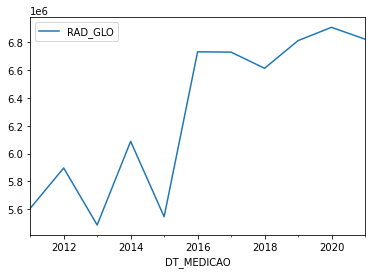

In [72]:
ts_anual.plot()

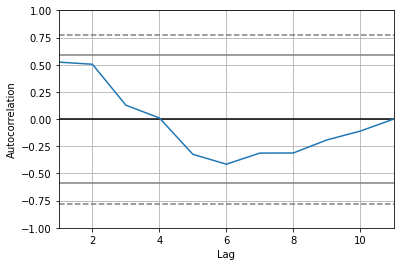

In [18]:
#Correlação entre os anos
autocorrelation_plot(ts_anual['RAD_GLO'])
plt.show()

In [19]:
#Séria Anual é estacionária
adfuller_test(ts_anual)

ADF Test Statistic : -0.57212904208503
p-value : 0.8771561836312038
#Lags Used : 1
Number of Observations Used : 9
weak evidence against null hypothesis, indicating it is non-stationary 


In [20]:
#Série dos anos de 2020 a 2021, para entendermos melhor os meses,
ts_2021=ts_rad['2020-01-01':'2021-12-31']

In [21]:
ts_2021.tail(5)

,RAD_GLO
DT_MEDICAO,
2021-12-31 19:00:00,82.676
2021-12-31 20:00:00,-3.069
2021-12-31 21:00:00,-2.758
2021-12-31 22:00:00,-2.203
2021-12-31 23:00:00,-2.051


In [22]:
#Agrupando a série em meses
ts_mensal=ts_2021.resample('m').sum()

<AxesSubplot:xlabel='DT_MEDICAO'>

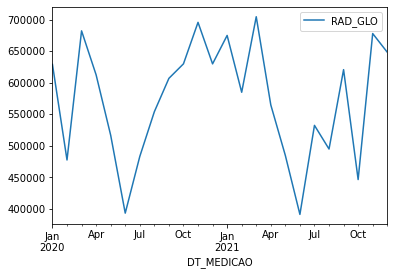

In [23]:
ts_mensal.plot()

<function matplotlib.pyplot.show(close=None, block=None)>

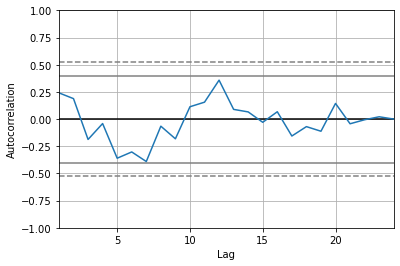

In [24]:
#Correlação dos meses
autocorrelation_plot(ts_mensal['RAD_GLO'])
plt.show

In [25]:
#agrupando os 2 anos em dias
ts_diario=ts_2021.resample('d').sum()

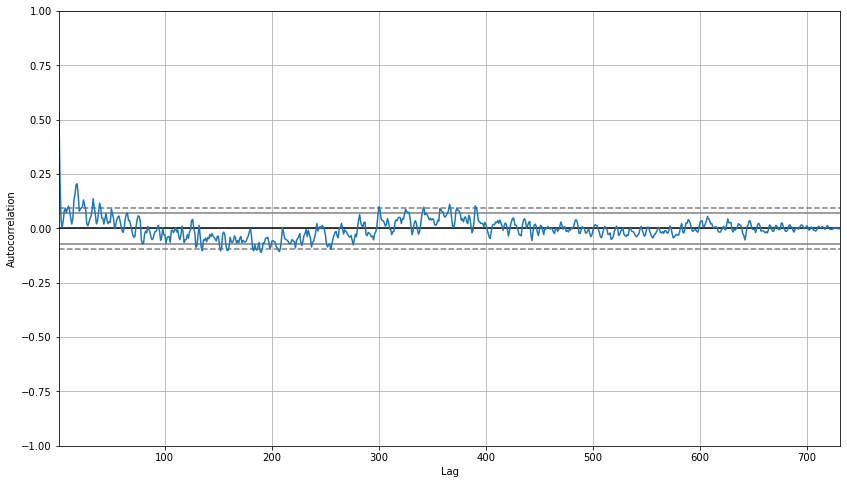

In [26]:
#Correlação dos dias
fig = plt.figure(figsize=(14,8))
ax1 = autocorrelation_plot(ts_diario['RAD_GLO'])
plt.show()

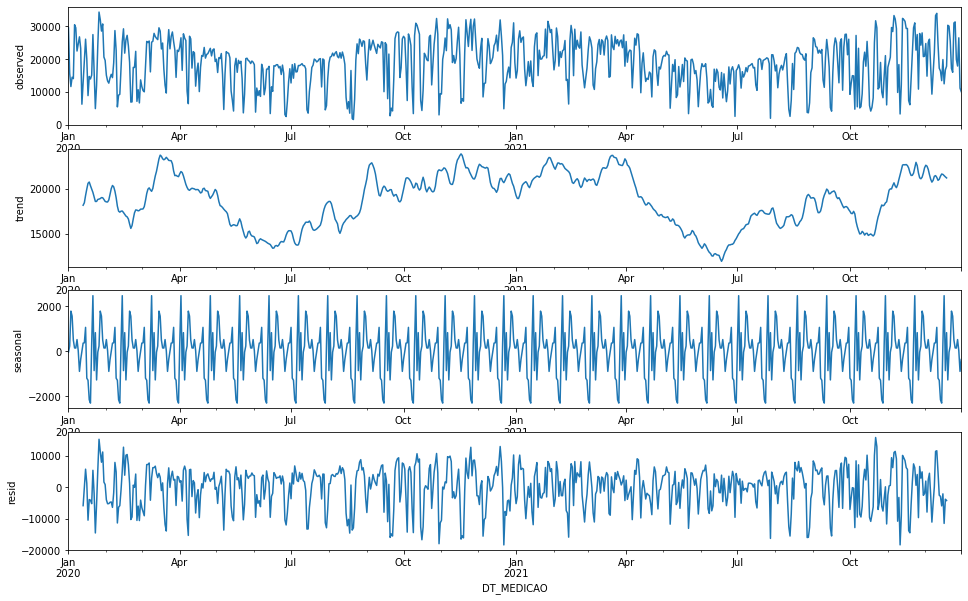

In [27]:
#Observando a séria anual agrupada por dias, se pode perceber:
#Existe um ciclo a cada ano, com um baixa geral nos meses proximos a junho
#Não há Tendência
#Existe uma Sazonalidade

# Additive Decomposition diário
decomposition_diario = seasonal_decompose(ts_diario, period=24)

fig, ax = plt.subplots(4, 1, figsize=(16, 10))
decomposition_diario.observed.plot(ax=ax[0]); ax[0].set_ylabel('observed')
decomposition_diario.trend.plot(ax=ax[1]); ax[1].set_ylabel('trend')
decomposition_diario.seasonal.plot(ax=ax[2]); ax[2].set_ylabel('seasonal')
decomposition_diario.resid.plot(ax=ax[3]); ax[3].set_ylabel('resid');

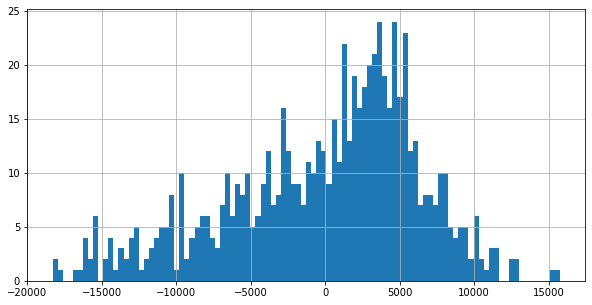

In [28]:
#Residuo não segue uma normal, resíduos ocorrem mais em torno de 5000
resid = decomposition_diario.resid
plt.figure(figsize=(10, 5))
resid.hist(bins=100);

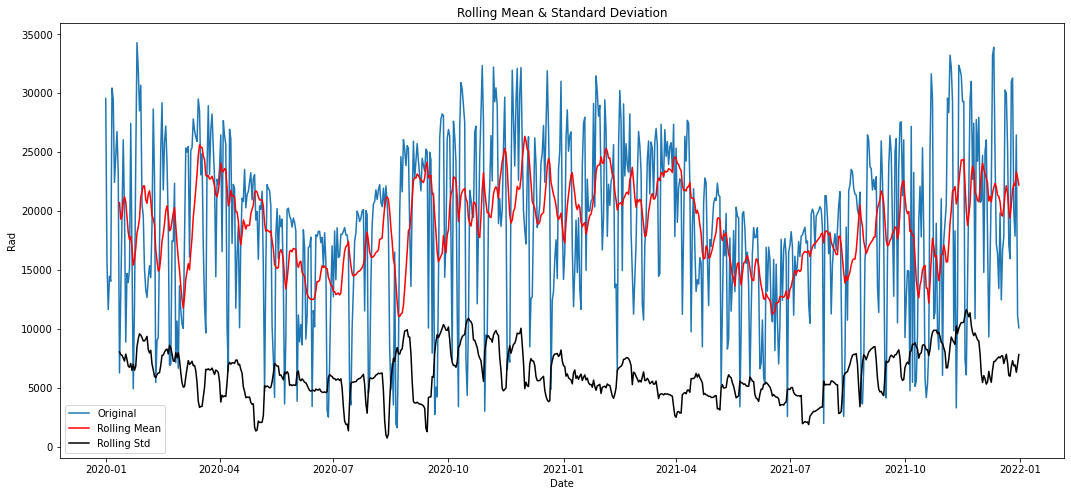

In [29]:
#Desvio padrão e Média distantes entre si
#Rolling statistics
rolmean = ts_diario.rolling(window=12).mean()
rolstd = ts_diario.rolling(window=12).std()
plt.figure(figsize=(18,8))   
orig = plt.plot(ts_diario, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean', c='r')
std = plt.plot(rolstd, label = 'Rolling Std', c='k')
plt.xlabel("Date")
plt.ylabel("Rad")
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

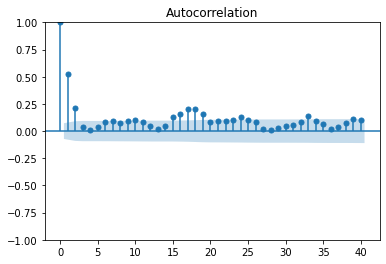

In [30]:
#correlação de 2 lags nos dias
plot_acf(ts_diario['RAD_GLO'], lags=40);

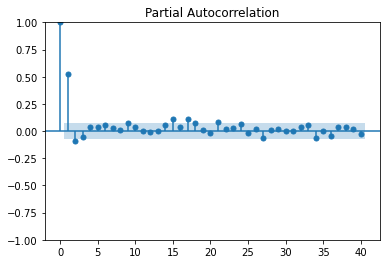

In [31]:
#Correlação de 1 lag no dia
plot_pacf(ts_diario['RAD_GLO'], lags=40);

## Vamos Trabalhar com a Série de um ano que representa um ciclo, dado que os anos parecem não influenciar entre si e variar muito pouco de um ano para outro nos ultimos anos.
## Os itervalos serão de hora em hora como visto a seguir.

In [66]:
#Série de um ano
ts_21 = ts_2021['2021-12-01':'2021-12-31']

In [68]:
# Ultimo dia da série 31/21/2022
ts_21.tail(5)

,RAD_GLO
DT_MEDICAO,
2021-12-31 19:00:00,82.676
2021-12-31 20:00:00,-3.069
2021-12-31 21:00:00,-2.758
2021-12-31 22:00:00,-2.203
2021-12-31 23:00:00,-2.051


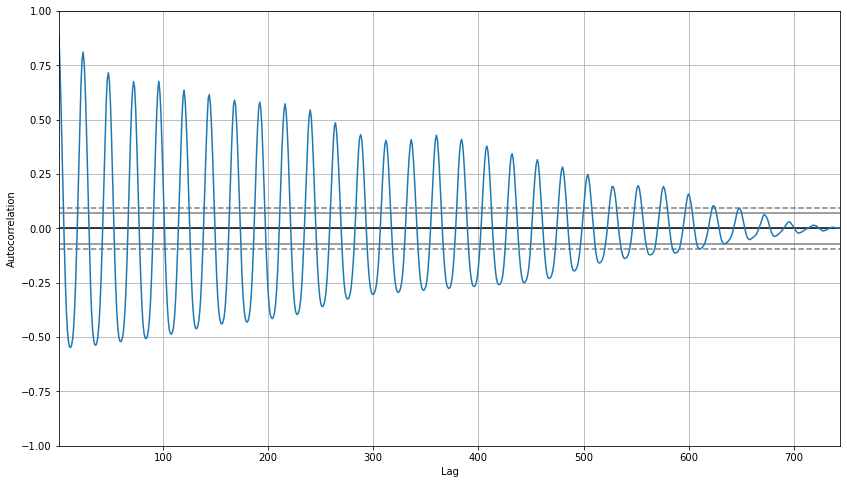

In [69]:
#Correlação das horas
fig = plt.figure(figsize=(14,8))
ax1 = autocorrelation_plot(ts_21['RAD_GLO'])
plt.show()

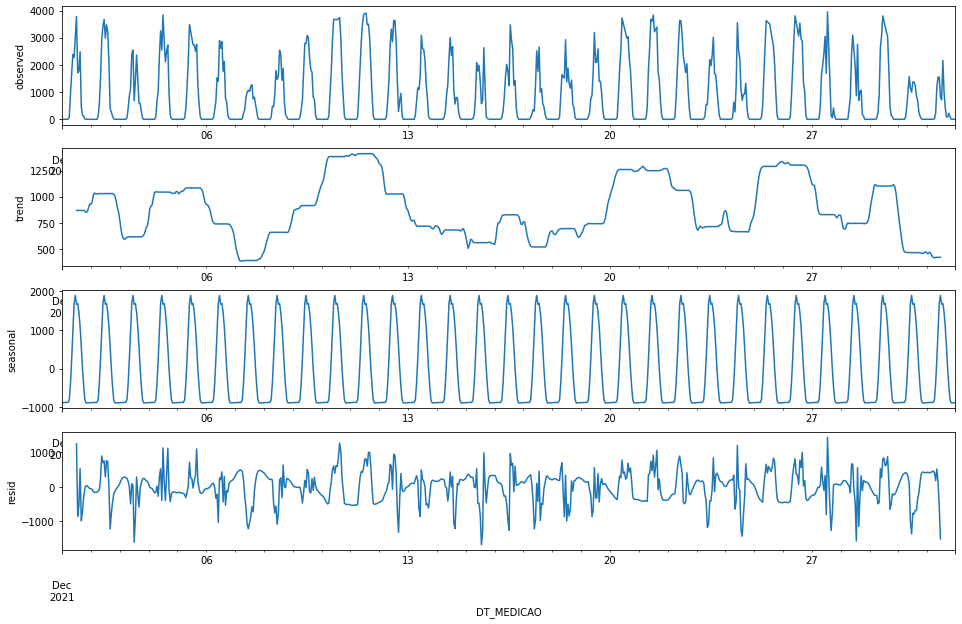

In [35]:
#Se oberserva uma queda na radiação no final do ano
#Não há Tendência
#Existe uma Sazonalidade de 24 horas(1 dia)

# Additive Decomposition diário
decomposition_horario = seasonal_decompose(ts_21, period=24)

fig, ax = plt.subplots(4, 1, figsize=(16, 10))
decomposition_horario.observed.plot(ax=ax[0]); ax[0].set_ylabel('observed')
decomposition_horario.trend.plot(ax=ax[1]); ax[1].set_ylabel('trend')
decomposition_horario.seasonal.plot(ax=ax[2]); ax[2].set_ylabel('seasonal')
decomposition_horario.resid.plot(ax=ax[3]); ax[3].set_ylabel('resid');

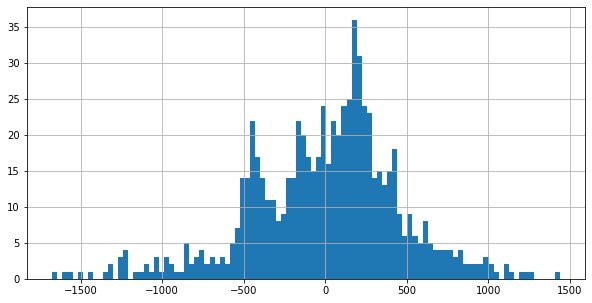

In [70]:
#Residuo não segue uma normal, resídui varia mais em torno de -500 e 500
resid = decomposition_horario.resid
plt.figure(figsize=(10, 5))
resid.hist(bins=100);

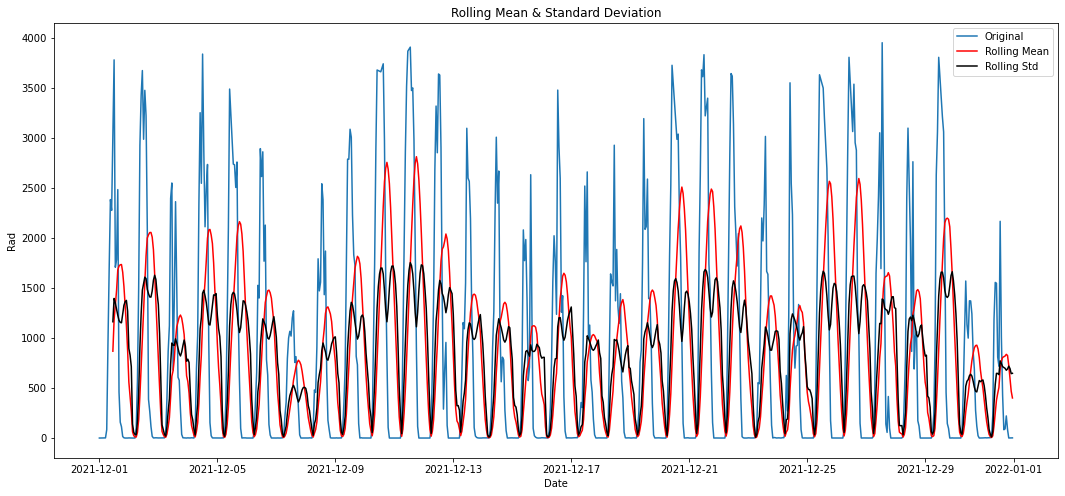

In [71]:
#Desvio padrão mais próximo da média do que no diário
#Rolling statistics
rolmean = ts_21.rolling(window=12).mean()
rolstd = ts_21.rolling(window=12).std()
plt.figure(figsize=(18,8))   
orig = plt.plot(ts_21, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean', c='r')
std = plt.plot(rolstd, label = 'Rolling Std', c='k')
plt.xlabel("Date")
plt.ylabel("Rad")
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

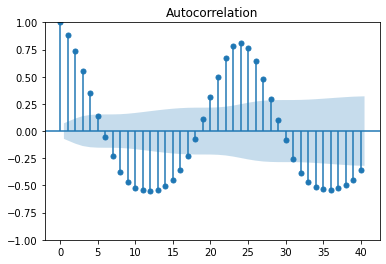

In [38]:
#correlação de 4 lags nos dias
plot_acf(ts_21['RAD_GLO'], lags=40);

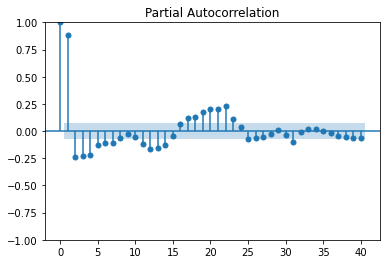

In [39]:
#correlação de 1 lags nos dias
plot_pacf(ts_21['RAD_GLO'], lags=40);

## Sarima

In [40]:
import statsmodels.api as sm

In [41]:
#foi utilizado para o Sarima:

#p=4 referente aos lags horários acf
#i=0 pois a série é estacionária e não foi necessário fazer diferenciação
#q=1 referente aos lags horários do pcaf

#foi utilizado para a Sazionalidade:

#p=2 referente aos lags Diários acf
#i=0 pois a série é estacionária e não foi necessário fazer diferenciação
#q=1 referente aos lags horários do pcaf
# e foi utilizado uma sazionalidade de 24 referente a 24 horas
model=sm.tsa.statespace.SARIMAX(ts_21['RAD_GLO'], order=(4,0,1), seasonal_order=(2,0,1,24))
model_fit=model.fit()

C:\Users\vhide\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\vhide\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\vhide\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
#Erro dos resíduos
mae = np.mean(np.abs(model_fit.resid))
print('MAE: %.3f' % mae)

MAE: 252.425


In [43]:
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            RAD_GLO   No. Observations:                  744
Model:             SARIMAX(4, 0, 1)x(2, 0, 1, 24)   Log Likelihood               -5585.317
Date:                            Fri, 15 Apr 2022   AIC                          11188.635
Time:                                    16:20:53   BIC                          11230.143
Sample:                                12-01-2021   HQIC                         11204.635
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5932      0.950      1.677      0.094      -0.269       3.456
ar.L2         -0.5845      0.583   

## Treino Teste

In [44]:
#Divisão de Treino e Teste
size=int(len(ts_21)*0.70)

In [45]:
Xtrain, Xteste=ts_21[0:size], ts_21[size:]

In [51]:
Xtrain.tail(5), Xteste.head(5)

(                      RAD_GLO
 DT_MEDICAO                   
 2021-12-22 11:00:00  3616.134
 2021-12-22 12:00:00  3135.240
 2021-12-22 13:00:00  2308.534
 2021-12-22 14:00:00  2032.192
 2021-12-22 15:00:00  1716.406,
                       RAD_GLO
 DT_MEDICAO                   
 2021-12-22 16:00:00  2041.273
 2021-12-22 17:00:00  1096.447
 2021-12-22 18:00:00   393.803
 2021-12-22 19:00:00    10.173
 2021-12-22 20:00:00    -1.564)

In [52]:
#Fit do Modelo de treino
model_new=sm.tsa.statespace.SARIMAX(Xtrain['RAD_GLO'], order=(4,0,1), seasonal_order=(2,0,1,24))
result=model.fit()

C:\Users\vhide\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\vhide\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\vhide\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [53]:
#De acorodo com o p os erros não parecem siginificantes
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            RAD_GLO   No. Observations:                  744
Model:             SARIMAX(4, 0, 1)x(2, 0, 1, 24)   Log Likelihood               -5585.317
Date:                            Fri, 15 Apr 2022   AIC                          11188.635
Time:                                    16:26:57   BIC                          11230.143
Sample:                                12-01-2021   HQIC                         11204.635
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5932      0.950      1.677      0.094      -0.269       3.456
ar.L2         -0.5845      0.583   

In [58]:
#criando a predição usando o treino
final_predicted=pd.DataFrame(model_fit.predict(start=len(Xtrain), end=len(ts_21)))
final_predicted.columns=['Pred']
final_predicted.head()

,Pred
2021-12-22 16:00:00,1132.338661
2021-12-22 17:00:00,1260.101270
2021-12-22 18:00:00,513.789061
2021-12-22 19:00:00,127.571432
2021-12-22 20:00:00,-17.151962


In [61]:
#Criando um df com a previsão e a base de teste
fully_final=pd.concat((final_predicted, Xteste), axis=1)
fully_final.head()

,Pred,RAD_GLO
2021-12-22 16:00:00,1132.338661,2041.273
2021-12-22 17:00:00,1260.101270,1096.447
2021-12-22 18:00:00,513.789061,393.803
2021-12-22 19:00:00,127.571432,10.173
2021-12-22 20:00:00,-17.151962,-1.564


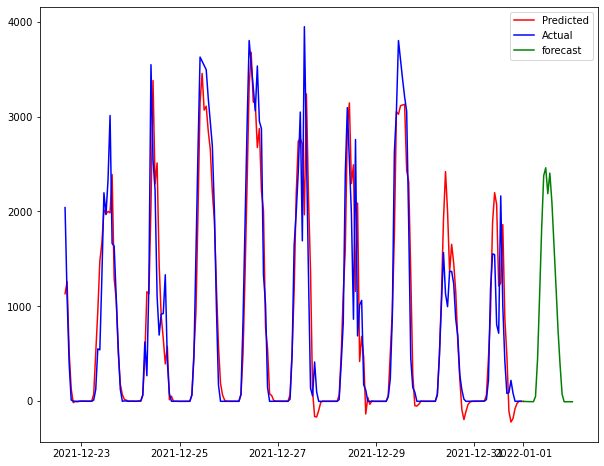

In [64]:
#Plotando a Previsão para o teste.
#Plotando o Forecast para as próximas 24 horas.
plt.figure(figsize=(10,8))
plt.plot(fully_final.index, fully_final['Pred'], color='red', label='Predicted')
plt.plot(fully_final.index, fully_final['RAD_GLO'], color='Blue', label='Actual')
plt.plot(pd.DataFrame(result.predict(start=len(ts_21), end=len(ts_21)+24)), color='green', label='forecast')
plt.legend()

In [65]:
#Foi claculado o erro em porcentagem pois é preferpivel dar mais relevância a erros altos do que a erros pequenos.
mean_absolute_porcentage_error(fully_final['RAD_GLO'], fully_final['Pred'])

382.87560828337763